### 區塊 1：導入必要的庫

file_paths = {
    'o3': 'o3_hourly_matrices.h5',
    'so2': 'so2_hourly_matrices.h5',
    'o3_8hr': 'o3_8hr_hourly_matrices.h5',
    'no2': 'no2_hourly_matrices.h5',
    'co_8hr': 'co_8hr_hourly_matrices.h5',
    'pm2.5_avg': 'pm2.5_avg_hourly_matrices.h5',
    'pm10_avg': 'pm10_avg_hourly_matrices.h5'
}

In [1]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### 區塊 2：載入 HDF5 文件中的數據

In [ ]:
import numpy as np
import pandas as pd
import h5py

def load_data(file_paths):
    data_dict = {key: [] for key in file_paths.keys()}
    timestamps = []

    for key, file_path in file_paths.items():
        with h5py.File(file_path, 'r') as f:
            for dataset_name in f.keys():
                timestamp = pd.to_datetime(dataset_name)
                data_dict[key].append((timestamp, f[dataset_name][:]))
                if timestamp not in timestamps:
                    timestamps.append(timestamp)
    
    # 確保每個時間點都有矩陣
    for key in data_dict.keys():
        data_dict[key] = sorted(data_dict[key], key=lambda x: x[0])

    return data_dict, sorted(timestamps)

# Load data
file_paths = {
    'so2': 'so2_hourly_matrices.h5'
}

data_dict, timestamps = load_data(file_paths)


In [3]:
# 找出數值最大的數據
max_value = -np.inf
max_timestamp = None

for key, data in data_dict.items():
    for timestamp, matrix in data:
        max_in_matrix = np.max(matrix)
        if max_in_matrix > max_value:
            max_value = max_in_matrix
            max_timestamp = timestamp

print(f"Maximum value in the dataset: {max_value}")
print(f"Timestamp of the maximum value: {max_timestamp}")

Maximum value in the dataset: 54.0
Timestamp of the maximum value: 2023-05-12 03:00:00


### 區塊 3：模型構建

In [ ]:
# 資料正規化
data = np.array([entry[1] for entry in data_dict['so2']])
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.reshape(-1, 16)).reshape(data.shape)

# 準備訓練資料
X = []
y = []

for i in range(data_scaled.shape[0] - 4):
    X.append(data_scaled[i:i+4])
    y.append(data_scaled[i+4])

X = np.array(X)
y = np.array(y)

# 切分訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 轉換為 CNN 所需的格式
X_train = X_train.reshape(X_train.shape[0], 4, 4, 4, 1)
X_test = X_test.reshape(X_test.shape[0], 4, 4, 4, 1)
y_train = y_train.reshape(y_train.shape[0], 16)
y_test = y_test.reshape(y_test.shape[0], 16)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14012, 4, 4, 4, 1) (14012, 16)
(3504, 4, 4, 4, 1) (3504, 16)


### 區塊 7：模型訓練

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed

# 建立模型
model = Sequential()

# CNN 部分
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=(4, 4, 4, 1)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

# LSTM 部分
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dense(16, activation='linear'))  # 將輸出大小設置為 25

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# 顯示模型架構
model.summary()

# 訓練模型
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# 評估模型
loss, rmse = model.evaluate(X_test, y_test)
print(f"Test RMSE: {rmse}")

/opt/miniconda3/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-06-11 02:24:28.841997: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-06-11 02:24:28.842014: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-11 02:24:28.842018: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-11 02:24:28.842035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-11 02:24:28.842044: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 4, 4, 4, 32)    │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 4, 2, 2, 32)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 4, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,768 (198.31 KB)

 Trainable params: 50,768 (198.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2024-06-11 02:24:29.285752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


351/351 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 0.0066 - root_mean_squared_error: 0.0796 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0629
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0634
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0636
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0639
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/st

### 區塊 4：模型評估

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


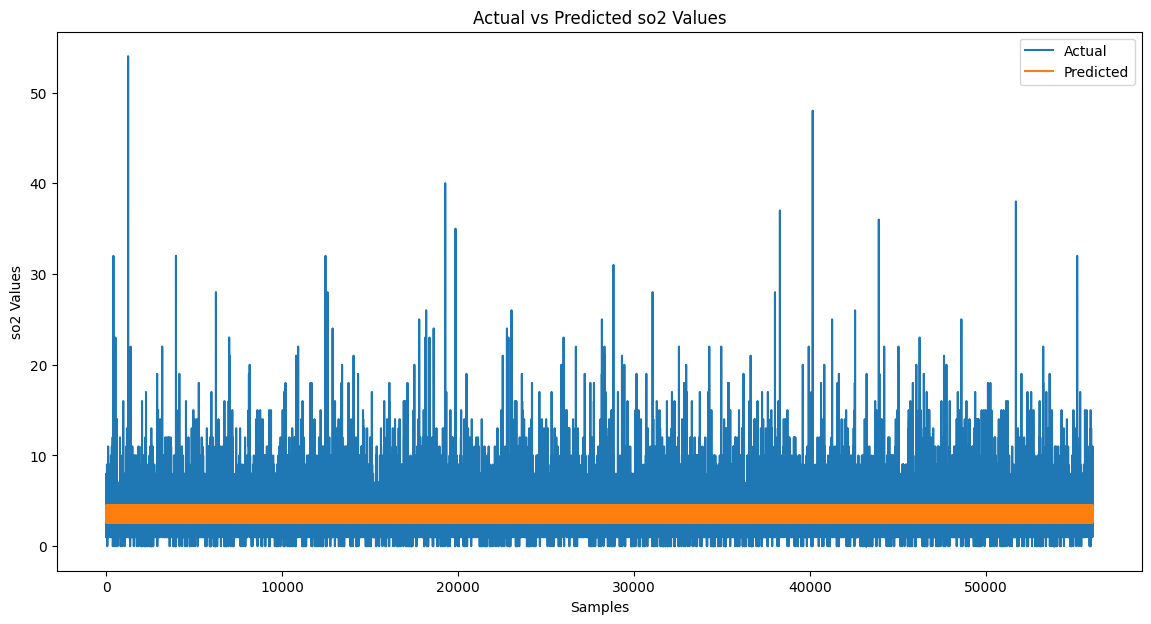

In [ ]:
import matplotlib.pyplot as plt

# 繪製訓練與驗證的損失值
y_pred = model.predict(X_test)

# 將預測值與實際值轉換為原始數值
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# 繪製預測值與實際值
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled.flatten(), label='Actual')
plt.plot(y_pred_rescaled.flatten(), label='Predicted')
plt.title('Actual vs Predicted so2 Values')
plt.xlabel('Samples')
plt.ylabel('so2 Values')
plt.legend()
plt.show()


In [ ]:
# 預測測試集
y_pred = model.predict(X_test)

# 比較每個站點的預測值和真實值
site_positions = {
    25.0: (3, 2),
    26.0: (2, 1),
    27.0: (2, 2),
    28.0: (1, 1),
    29.0: (1, 0),
    30.0: (1, 2),
    31.0: (2, 0),
    32.0: (3, 0),
    33.0: (3, 1),
    34.0: (0, 0),
    35.0: (0, 1),
    37.0: (0, 2),
    38.0: (0, 3),
    41.0: (1, 3),
    54.0: (2, 3),
    83.0: (3, 3)
}

# 將預測值和真實值轉換為站點對應的值
site_errors = {siteid: [] for siteid in site_positions.keys()}
for i in range(len(y_test_rescaled)):
    actual_values = y_test_rescaled[i].reshape(4, 4)
    predicted_values = y_pred_rescaled[i].reshape(4, 4)
    for siteid, (row, col) in site_positions.items():
        actual_value = actual_values[row, col]
        predicted_value = predicted_values[row, col]
        error = abs(actual_value - predicted_value)
        site_errors[siteid].append(error)

# 計算每個站點的平均絕對誤差
average_errors = {siteid: np.mean(errors) for siteid, errors in site_errors.items()}

# 印出結果
for siteid, avg_error in average_errors.items():
    print(f"Site {siteid}: Average Absolute Error = {avg_error}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Site 25.0: Average Absolute Error = 1.4350895870766138
Site 26.0: Average Absolute Error = 1.279405910947007
Site 27.0: Average Absolute Error = 1.27988191500102
Site 28.0: Average Absolute Error = 0.8797672540629835
Site 29.0: Average Absolute Error = 1.329277969658647
Site 30.0: Average Absolute Error = 1.5042516231264698
Site 31.0: Average Absolute Error = 1.1378685676888243
Site 32.0: Average Absolute Error = 1.944351106201677
Site 33.0: Average Absolute Error = 2.1256920866770286
Site 34.0: Average Absolute Error = 1.7992455191808203
Site 35.0: Average Absolute Error = 1.1205617471100533
Site 37.0: Average Absolute Error = 1.4264465603109908
Site 38.0: Average Absolute Error = 1.6945245630664914
Site 41.0: Average Absolute Error = 1.02990734876563
Site 54.0: Average Absolute Error = 1.328936740687993
Site 83.0: Average Absolute Error = 1.0967875123023987


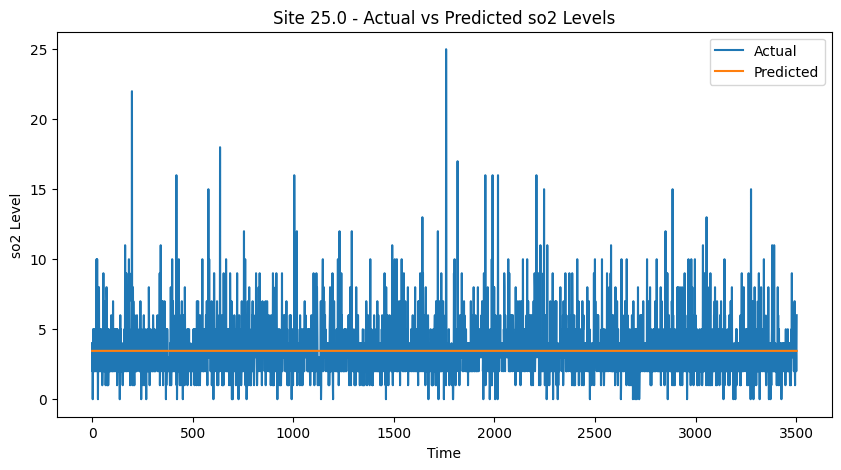

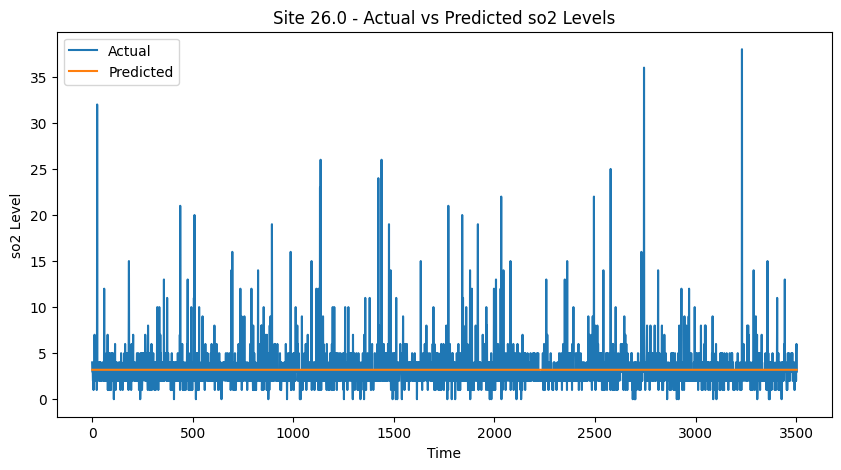

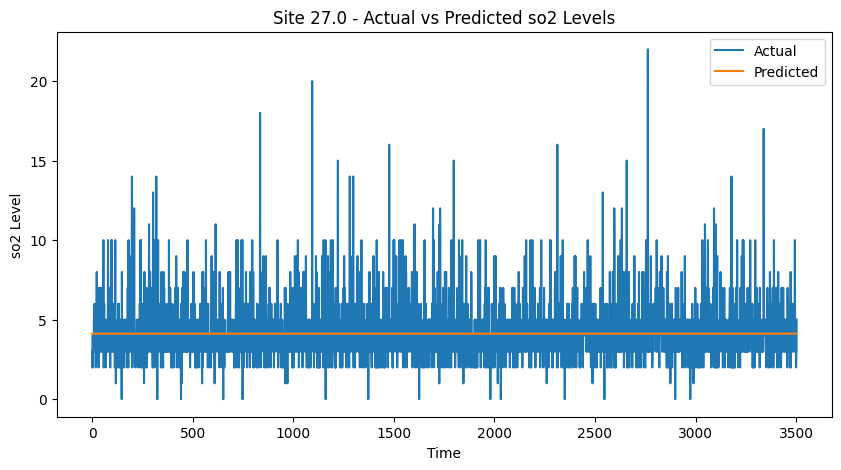

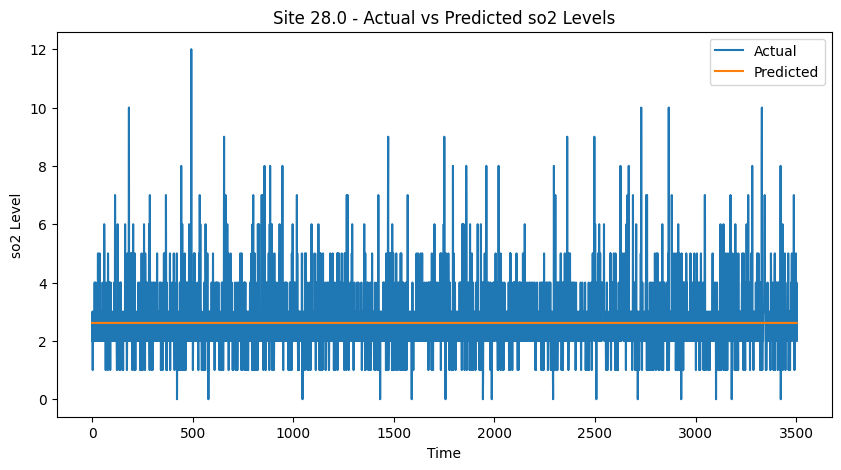

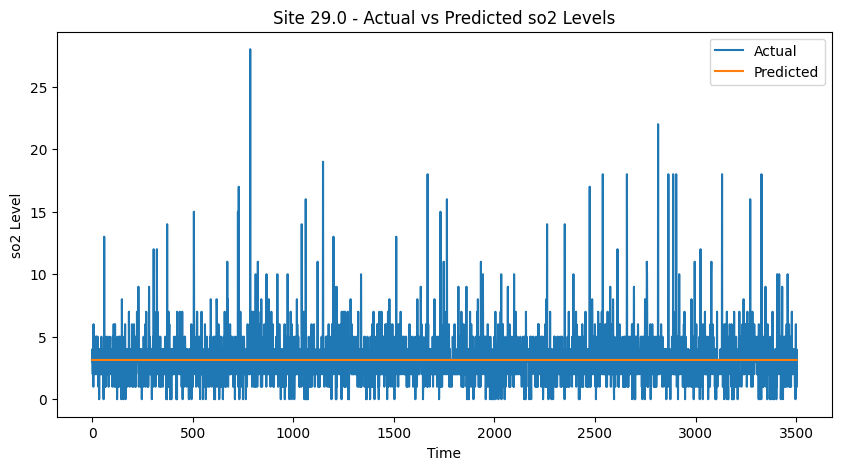

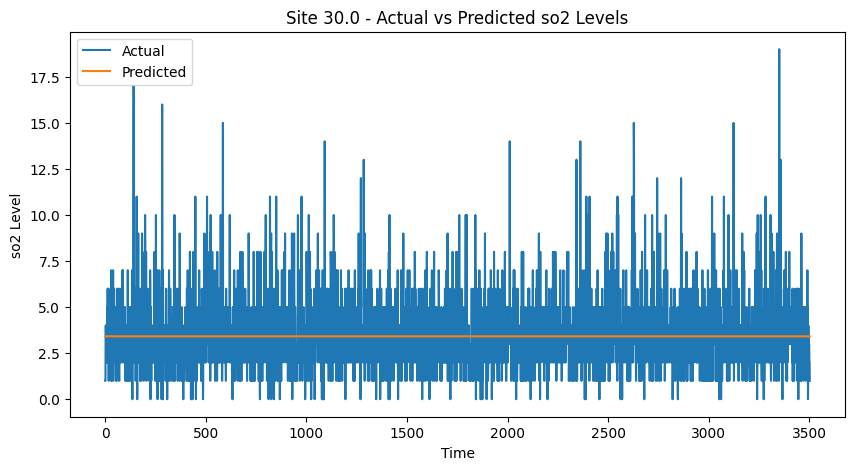

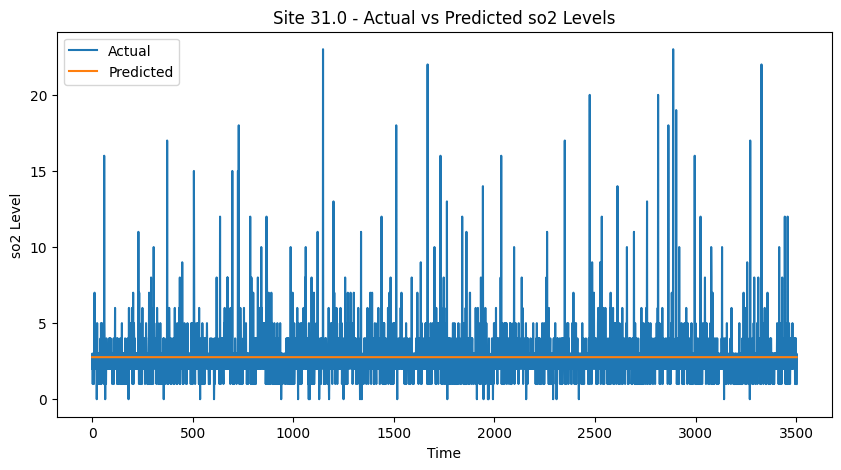

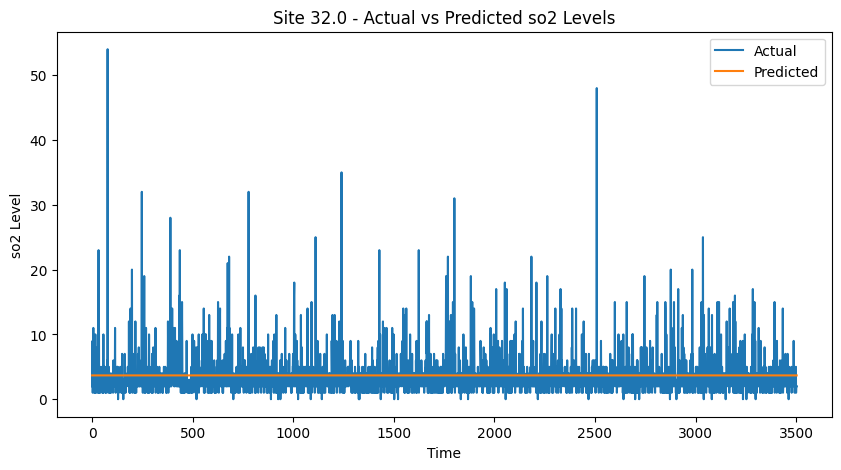

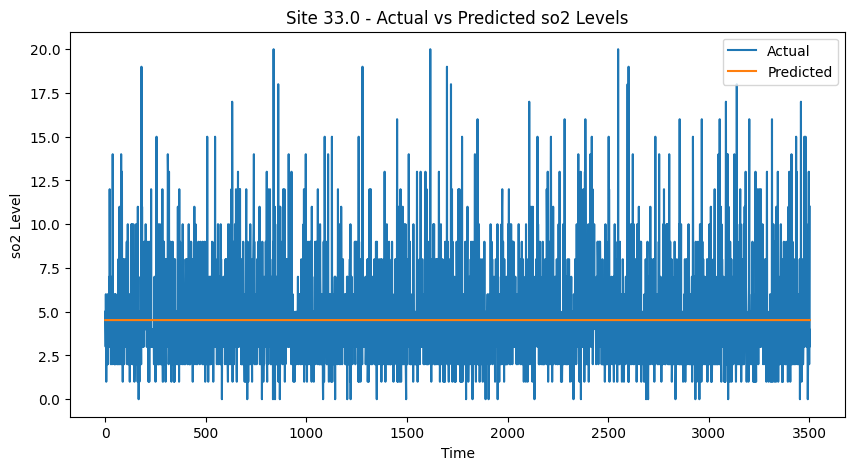

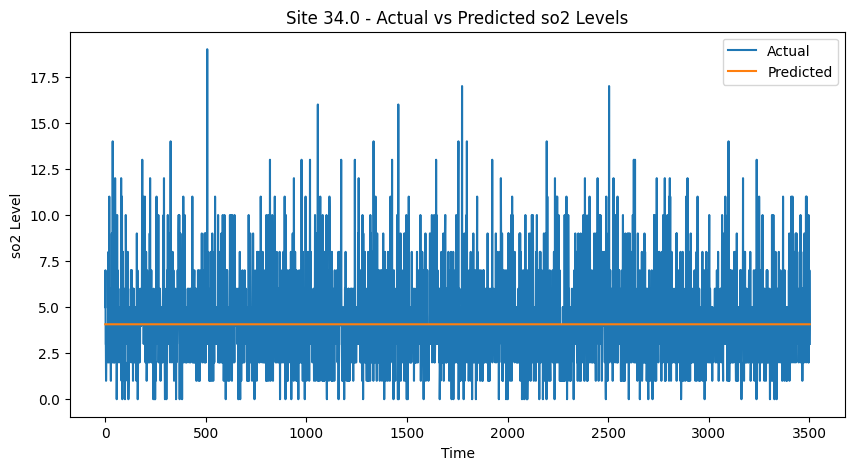

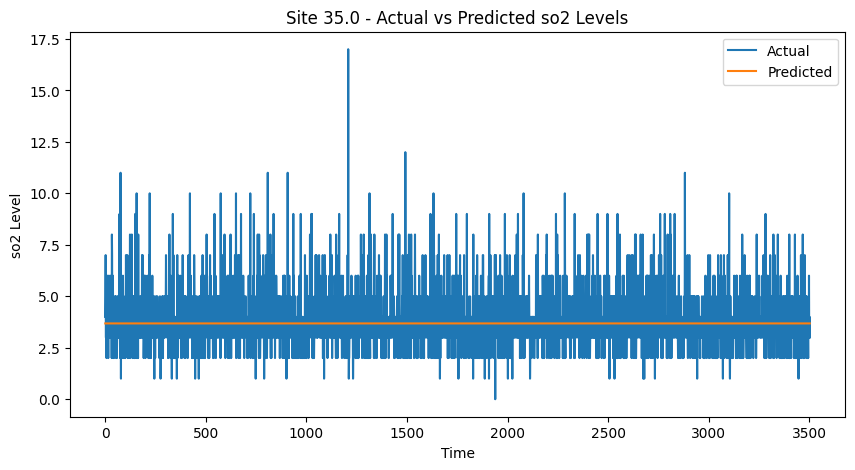

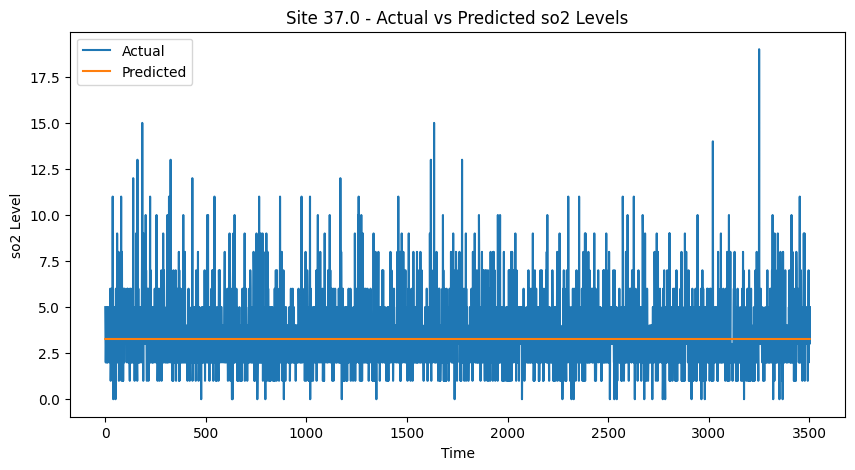

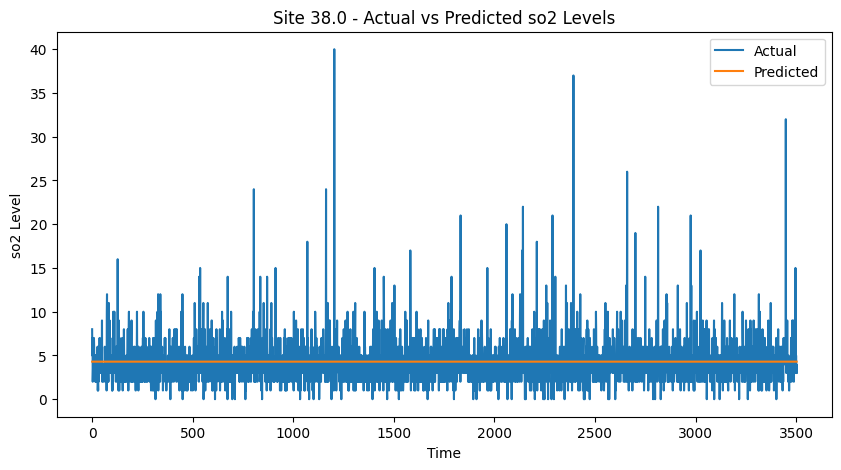

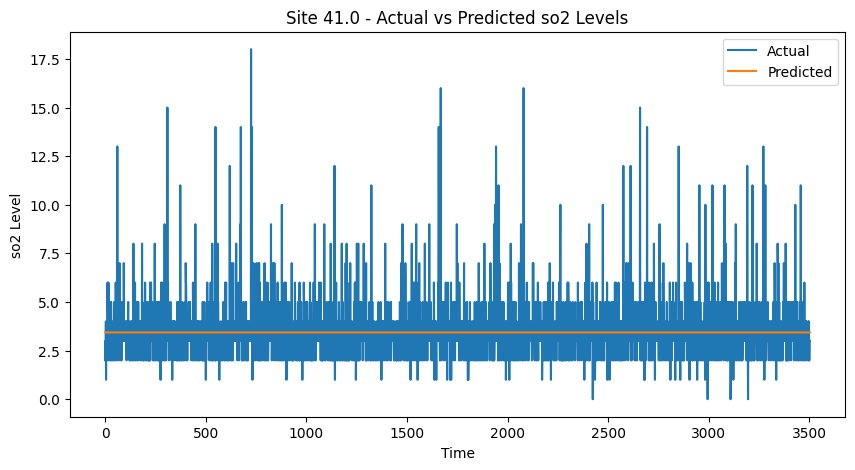

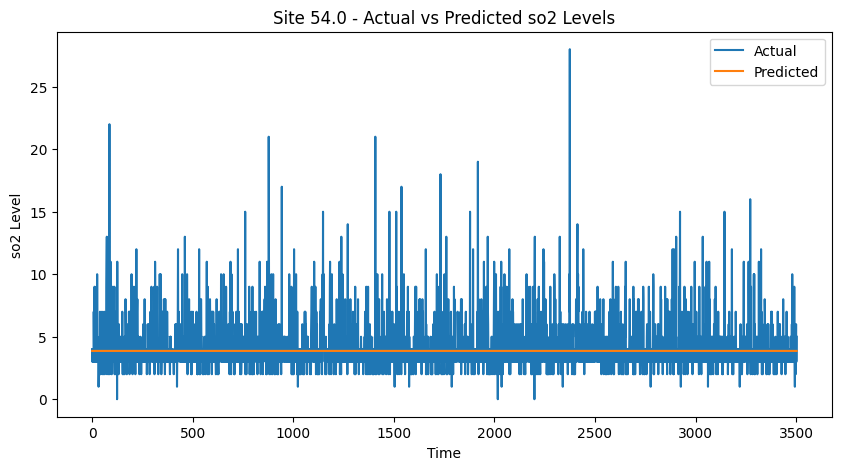

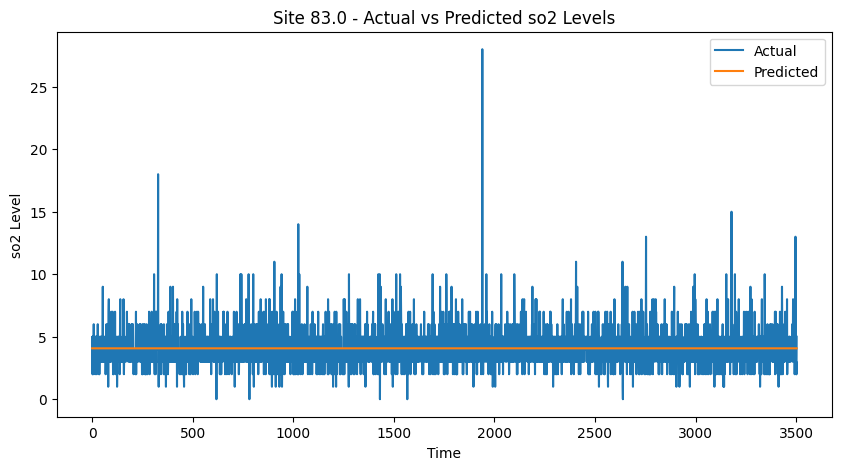

In [8]:
# 將預測值和真實值轉換為站點對應的值
site_actuals = {siteid: [] for siteid in site_positions.keys()}
site_predictions = {siteid: [] for siteid in site_positions.keys()}

for i in range(len(y_test_rescaled)):
    actual_values = y_test_rescaled[i].reshape(4, 4)
    predicted_values = y_pred_rescaled[i].reshape(4, 4)
    for siteid, (row, col) in site_positions.items():
        actual_value = actual_values[row, col]
        predicted_value = predicted_values[row, col]
        site_actuals[siteid].append(actual_value)
        site_predictions[siteid].append(predicted_value)

# 繪製每個站點的真實數據和預測數據
for siteid in site_positions.keys():
    plt.figure(figsize=(10, 5))
    plt.plot(site_actuals[siteid], label='Actual')
    plt.plot(site_predictions[siteid], label='Predicted')
    plt.title(f'Site {siteid} - Actual vs Predicted so2 Levels')
    plt.xlabel('Time')
    plt.ylabel('so2 Level')
    plt.legend()
    plt.show()